# 投资组合分析
# 分析投资组合的最佳分配（解决有约束的求极值问题）

## 一、构建类获取股票交易数据
数据API: https://www.alphavantage.co/documentation/  API KEY:34A4VP32WLWXG9WG

由于这个API的python版document写的不详细，因此我们选择自己解析获取到的数据并且使用pandas处理
### 从网上读取数据，选择想要的股票数据，将json数据格式解析成pandas Frame 用于后续计算

In [1]:
import urllib3
import json
import pandas as pd
class Stock(object):
    def __init__(self):
        self.api_address = "https://www.alphavantage.co/"
        self.key = "34A4VP32WLWXG9WG"
        #       首先根据urllib3的文档，建立http连接池
        self.http = urllib3.PoolManager()
        
#   以日为单位，获取交易信息记录，输入 股票symbols(列表)， 返回近20年的股票记录
    def stocks_daily_query(self, symbols):
        
#       init 总的dataFrame作为返回值，假定行表示股票名，列是时间，数据是close price
        stock_frame = pd.DataFrame()
        

#       定义function为TIME_SERIES_DAILY 表示以日为单位查询
        function = "TIME_SERIES_DAILY"
    
    
#       循环开始：遍历所有的symbols,  股票名为symbol
        for symbol in symbols:
#           动态构建获取数据的地址 web_address 
#           地址格式如同 https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&apikey=demo
            web_address = "%squery?function=%s&symbol=%s&apikey=%s"    % (self.api_address, function, symbol,self.key)
#             web_address = "%squery?function=%s&symbol=%s&outputsize=full&apikey=%s"    % (self.api_address, function, symbol,self.key)
#           使用http.request请求页面
            r = self.http.request('GET', web_address)
#           请求得到的r.data是byte格式，先转换成str 再使用 json 格式保存
            j = json.loads(r.data.decode('utf-8'))
            if len(j)>=2:
#                 print(j)
    #           这个字段中只有time series (Daily)的信息有用，将其中的信息取出,并将格式从dict转换成str
                d = json.dumps(j["Time Series (Daily)"])

    #           构建 pandas dataFrame来存储数据
                df = pd.read_json(d, orient='index')
    #           需要close价格，取出该列。并改名
                close_price = df.loc[:,['4. close']]
                close_price.columns = ["%s_price" % symbol]
    #           将该列加入到总的stock_frame中
                stock_frame = pd.concat([stock_frame,close_price],axis=1)
    #           需要volume总量取出该列。并改名
                volume = df.loc[:,['5. volume']]
                volume.columns = ["%s_volume" % symbol]
    #           将该列加入到总的stock_frame中
                stock_frame = pd.concat([stock_frame,volume],axis=1)
    
        
        return stock_frame

In [23]:
# 查询 AAPL 苹果公司， ACGBY 中国建设银行， AMZN 亚马逊， KO 可口可乐， GOOG 谷歌
p = Stock()
stock_frame = p.stocks_daily_query(["AAPL","ACGBY","AMZN","KO","GOOG"])

C:\Users\surface\Anaconda2\envs\tensorflow\lib\site-packages\urllib3\connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\Users\surface\Anaconda2\envs\tensorflow\lib\site-packages\urllib3\connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\Users\surface\Anaconda2\envs\tensorflow\lib\site-packages\urllib3\connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\Users\surface\Anaconda2\envs\tensorflow\lib\site-packag

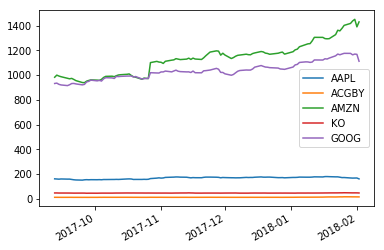

In [5]:
stock_frame.plot.line()

#### 标准化数据 显示单位股价变化情况

使用sklearn 包的 preprocess函数 使用z-score standardScaler

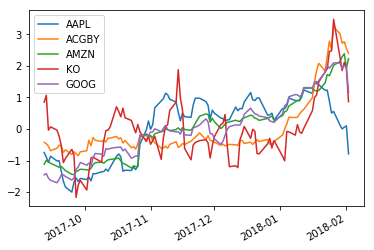

In [6]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(stock_frame)
stock_frame_standard = pd.DataFrame(scaler.transform(stock_frame),columns= stock_frame.columns,index=stock_frame.index)   
stock_frame_standard.plot.line()

#### 显示收益率

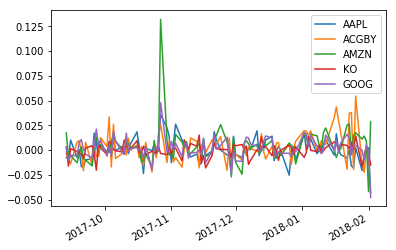

In [7]:
return_rate_frame = (stock_frame-stock_frame.shift(1))/stock_frame.shift(1)
return_rate_frame.plot.line()

## 二、预测最佳投资组合
业务逻辑参考

https://community.bigquant.com/t/%E9%87%8F%E5%8C%96%E5%AD%A6%E5%A0%82-%E7%AD%96%E7%95%A5%E5%BC%80%E5%8F%91%E4%BD%BF%E7%94%A8cvxopt%E5%8C%85%E5%AE%9E%E7%8E%B0%E9%A9%AC%E7%A7%91%E7%BB%B4%E8%8C%A8%E6%8A%95%E8%B5%84%E7%BB%84%E5%90%88%E4%BC%98%E5%8C%96%E4%BB%A5%E4%B8%80%E4%B8%AA%E8%82%A1%E7%A5%A8%E7%AD%96%E7%95%A5%E4%B8%BA%E4%BE%8B/274

使用 seaborn 可视化
https://seaborn.pydata.org/installing.html

## （1）查看组合收益率与波动性的关系

In [8]:
# 产生随机数函数， 随机产生分配方案
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

### 投资组合收益率和波动性计算

投资组合收益率公式 $\mu = p^Tw$

波动性公式 $\sigma = \sqrt{w^T*C*w}$

In [25]:
# 返回组合收益率和波动性
def random_portfolio(returns):
    """ input 收益矩阵, output 组合收益率和波动性 """
    p = np.asmatrix(np.mean(returns, axis=1))# 周期内每只股票的平均收益
    w = np.asmatrix(rand_weights(returns.shape[0]))# 随机生成分配方案
    C = np.asmatrix(np.cov(returns))#周期内每只股票的收益波动

    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # 过滤器 仅允许 波动性小于0.01的投资组合
    if sigma > 0.02:
        return random_portfolio(returns)
    
    return mu, sigma

### 随机生成5000个投资组合 并显示组合收益率和波动性的关系

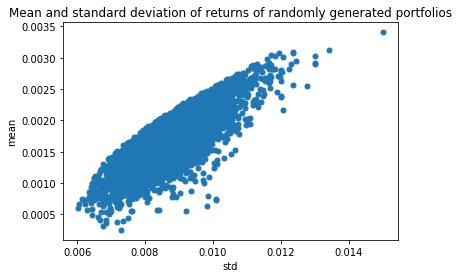

In [26]:
import numpy as np
import matplotlib.pyplot as plt
# 提取出 dataframe 中的 matrix 
# 注意此处的 line-column 分别表示的含义，需要转置
return_vec = return_rate_frame.as_matrix()[1:].T

n_portfolios = 5000 #5000个投资组合
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in range(n_portfolios)
])
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std') # 标准差-波动性
plt.ylabel('mean') # 平均值-收益率
plt.title('Mean and standard deviation of returns of randomly generated portfolios') # 每个投资组合的收益率和波动性的散点图
plt.show()

## （2）马科维茨优化和有效前沿
计算在特定波动性条件下的最高收益率，或计算在特定收益率条件下的最低波动性。可以抽象成解决凸优化的问题。

本次使用 cvxopt 来处理凸优化问题 http://cvxopt.org/examples/index.html

具体使用CVXOPT教程 https://wizardforcel.gitbooks.io/python-quant-uqer/content/192.html

如果windows遇到LLD问题，可以参考 https://stackoverflow.com/questions/46009925/how-to-install-cvxopt-on-on-windows-10-on-python-3-6

### （2）i. 特定收益率条件下的最低波动
目标函数 $w^TC*w$ 

限制条件$\sum_{i=1}^nw_i=1$ 并且 $\mu = p^Tw = t$ t为特定收益率

输出为 组合权重 w

[0.1, 0.11220184543019636, 0.12589254117941673, 0.14125375446227545, 0.15848931924611134, 0.1778279410038923, 0.19952623149688797, 0.22387211385683395, 0.251188643150958, 0.28183829312644537, 0.31622776601683794, 0.35481338923357547, 0.3981071705534972, 0.44668359215096315, 0.5011872336272722, 0.5623413251903491, 0.6309573444801934, 0.7079457843841379, 0.7943282347242815, 0.8912509381337455, 1.0, 1.1220184543019636, 1.2589254117941675, 1.412537544622754, 1.5848931924611134, 1.7782794100389228, 1.9952623149688797, 2.23872113856834, 2.5118864315095797, 2.8183829312644537, 3.1622776601683795, 3.548133892335755, 3.981071705534973, 4.46683592150963, 5.011872336272722, 5.623413251903491, 6.309573444801933, 7.07945784384138, 7.943282347242813, 8.912509381337454, 10.0, 11.220184543019629, 12.589254117941675, 14.12537544622754, 15.848931924611142, 17.78279410038923, 19.952623149688787, 22.3872113856834, 25.118864315095795, 28.18382931264455, 31.622776601683793, 35.481338923357534, 39.8107170553

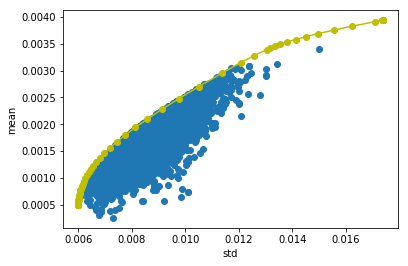

In [27]:
import cvxopt as opt
from cvxopt import blas, solvers
# 关掉进度展示，进度展示是运行过程进度的一个打印输出，可以通过其查看代码运行进度
solvers.options['show_progress'] = False
def optimal_portfolio_stableReturn(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # 转化为cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # 约束条件
    G = -opt.matrix(np.eye(n))   # opt默认是求最大值，因此要求最小化问题，还得乘以一个负号
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # 使用凸优化计算有效前沿
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## 计算有效前沿的收益率和风险
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # 计算最优组合
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio_stableReturn(return_vec)

plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')

In [28]:
print('最优组合' ,weights)

最优组合 [[  1.13626987e-07]
 [  3.24092680e-08]
 [  9.99999579e-01]
 [  1.13150059e-07]
 [  1.61559165e-07]]


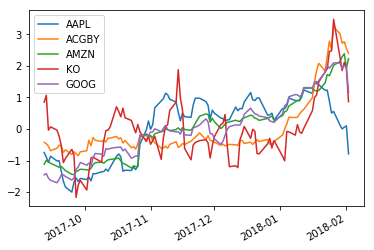

In [29]:
stock_frame_standard.plot.line()